# Production statistics

In [382]:
import math

import pandas as pd
from molmass import Formula
import reframed

In [383]:
import sys
sys.path.append("../functions/")
import general_functions as general_func

import colors_MAGs
import scipy.stats as stats

In [384]:
import numpy as np

In [385]:
import os

In [386]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load universal model

In [387]:
model_uni = reframed.load_cbmodel("/Users/idunmariaburgos/universal_model_extension/output/universe_bacteria.xml")

### Load data 

In [388]:
all_mags_paper = general_func.read_allmags_data()

In [389]:
SC1_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])

steadier_sample["mass_rate"] = steadier_sample["mass_rate"]*1000
steadier_sample = steadier_sample[(steadier_sample.rate>1e-6)]

### Prepare to process data

In [390]:
chebi_lut, chebi_interesting, chebi_colors_ser = colors_MAGs.chebi_rxn_color_func(rxn_based=False)

**Change names of family for readability and better grouping**

In [391]:
all_mags_paper_reduced = all_mags_paper.copy()

all_mags_paper_reduced[all_mags_paper_reduced["new_coverage"]>10][["Source","Substrate","Family","new_coverage"]].sort_values(["Source","Substrate"])

all_mags_paper_reduced["Family"] = all_mags_paper.apply(lambda row: "f_"+row.Family,axis=1)

total_members_family = all_mags_paper_reduced.groupby("Family").count()["Source"].to_dict()
all_mags_paper_reduced["Family"] = all_mags_paper_reduced.apply(lambda row: row.Family if total_members_family[row.Family]>1 else "Other",axis=1)


In [392]:
def mag2family(all_mags_paper):  
    
    family_groups = all_mags_paper.groupby("Family").groups
    mag2family_dict = {mag:family for family,mags in family_groups.items() for mag in mags}
    
    return family_groups,mag2family_dict

**Create dictionaries to translate components into larger groups - MAG-> family, compound-> super_class**

In [393]:
MAGs_steady_com = list(set(steadier_sample_prod.donor.values))

MAG2sour_sub_id = pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None)
MAG2sour_sub_id.columns=["MAG","community_id"]

met2superclass_dict = pd.read_csv("../output/met_chebi_class.tsv",sep="\t",index_col=0)["self defined super class"].to_dict()

family_groups,mag2family_dict = mag2family(all_mags_paper_reduced)

In [394]:
def family_donor(row):
    if row.donor=="environment":
        return "environment"
    else:
        return mag2family_dict[row.donor]


def family_receiver(row):
    if row.receiver=="environment":
        return "environment"
    else:
        return mag2family_dict[row.receiver]


In [395]:
def met2metname(met):
    met_name = model_uni.metabolites[met].name
    return met_name

### Process data

In [396]:
change_name_dict = {"Isobutyrate":"Isobutyric acid",
"2 methylpropanoic acid":"Isobutyric acid",
"Propionate (n-C3:0)":"Propionic acid",                                                                            
"Butyrate (n-C4:0)":"Butyric acid",
"L-Lactate":"L-Lactic acid",
"Formate":"Formic acid",
"Acetate":"Acetic acid",
"Hexanoate (n-C6:0)":"Caproic acid",
"CO2 CO2":"CO2",
"L-Malate":"L-Malic acid",
"D-Aspartate":"D-Aspartic acid",
"L-Aspartate":"L-Aspartic acid",
"Thymine C5H6N2O2":"Thymine",
"Glycolate C2H3O3":"Glycolic acid",
"R Acetoin C4H8O2":"R Acetoin",
"Protoheme C34H30FeN4O4": "Protoheme"
}

def change_name(x):
    if x in change_name_dict.keys():
        return change_name_dict[x]
    else:
        return x


**All compounds**

In [397]:
steadier_sample.loc[:,"family_donor"] = steadier_sample.apply(family_donor,axis=1).copy()
steadier_sample.loc[:,"family_receiver"] = steadier_sample.apply(family_receiver,axis=1).copy()
steadier_sample = steadier_sample[steadier_sample.compound.isin(met2superclass_dict.keys())].copy()
steadier_sample.loc[:,"super_class"] = steadier_sample.apply(lambda x: met2superclass_dict[x.compound],axis=1)

compounds = steadier_sample["compound"].map(met2metname)
compounds = compounds.map(change_name)
steadier_sample.drop("compound",axis=1,inplace=True)
steadier_sample.loc[:,"compound"] = compounds
steadier_sample["mass_rate*frequency"]=steadier_sample.mass_rate*steadier_sample.frequency

**Compounds produced**

In [398]:
steadier_sample_prod = steadier_sample[(steadier_sample.receiver=="environment") ].copy()

# FILTERS OUT UNINTERESTING COMPOUNDS
#steadier_sample_prod = steadier_sample_prod[steadier_sample_prod.super_class.isin(chebi_lut.keys())].copy()

### Overview of groups

In [399]:
pd.Series({family:len(mags) for family,mags in family_groups.items()})

Other                    19
f_Bacteroidaceae          4
f_CAG-74                  2
f_Clostridiaceae          3
f_Desulfobulbaceae        2
f_Desulfovibrionaceae    12
f_Dysgonomonadaceae       4
f_Fibrobacteraceae        2
f_Lachnospiraceae         8
f_Lactobacillaceae        2
f_Lentimicrobiaceae       2
f_Sphaerochaetaceae       6
f_Treponemataceae         4
f_Verruco-01              3
dtype: int64

## Production by taxonomy

In [400]:
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import seaborn as sns

In [401]:
import colors_MAGs as color_func

In [402]:
phyla_lut, unique_phyla, phylum_colors = color_func.phylum_colors_func()

families = list(set(list(steadier_sample.family_donor.unique()) + list(steadier_sample.family_receiver.unique())))

In [403]:
families.remove("Other")
families.remove("environment")

phyla = [all_mags_paper.loc[all_mags_paper.loc[all_mags_paper.Family==family.split("_")[1]].index]["Phylum"][0] for family in families]
colors = [phyla_lut[phylum] for phylum in phyla]

families.append("Other")
colors.append("#808080")

color_df = pd.DataFrame({"Family_names":families,"Phylum":colors})
color_df.set_index("Family_names",inplace=True)

### Production: Most shared compounds

In [404]:
from matplotlib.pyplot import gcf

In [405]:
steadier_sample_not_from_env = steadier_sample[(steadier_sample.donor!="environment") ].copy()

steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()
steadier_sample_prod_overview = steadier_sample_prod_overview.T/steadier_sample_prod_overview.sum(axis=1)

In [406]:
steadier_sample_prod_overview = steadier_sample_prod_overview.T[["D-Xylose","Acetaldehyde","D-Glucose","D-Ribose","L-Lactic acid","L-Malic acid","D-Glyceraldehyde"]]
#steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()

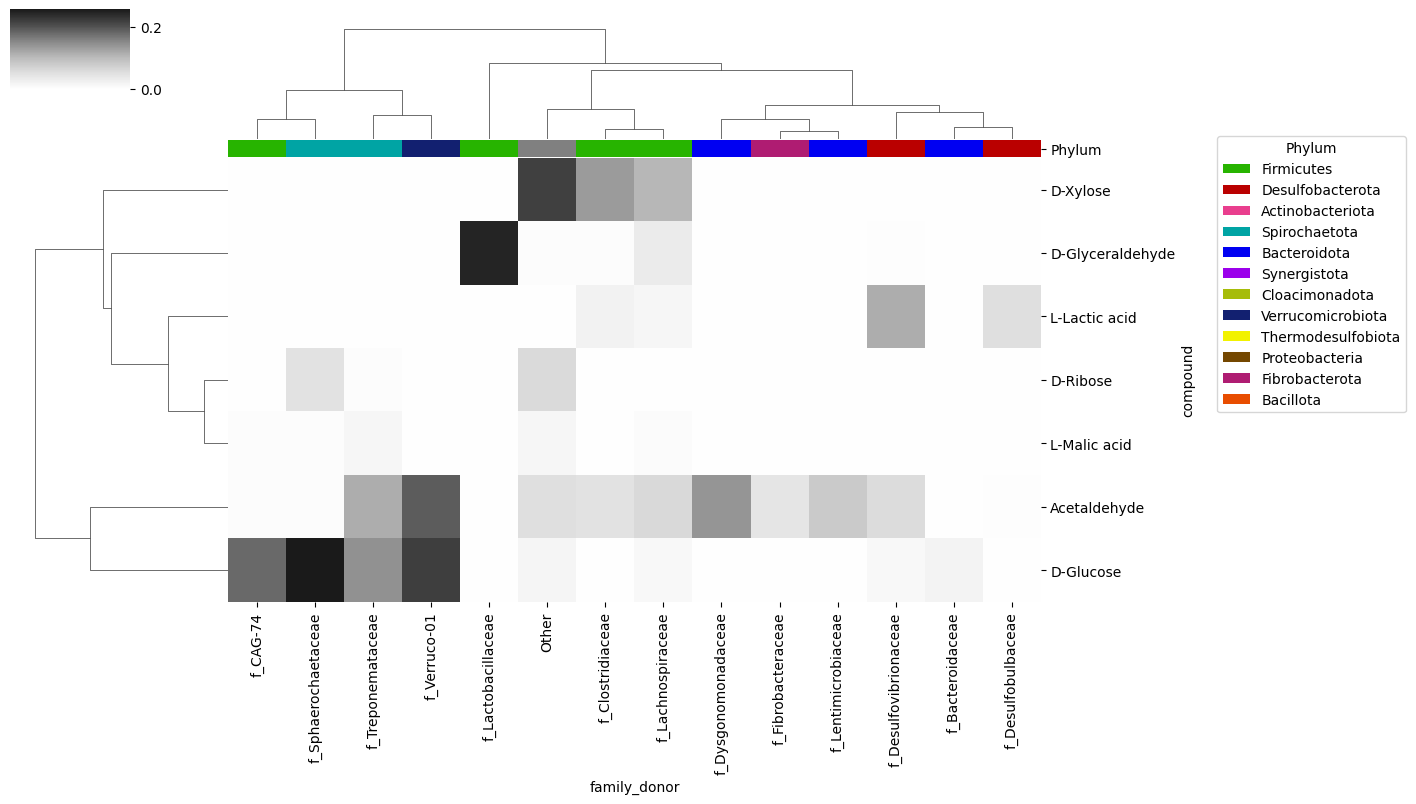

In [407]:
fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.01,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,8),
                cbar_pos=(0,0.9,0.1,0.1))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/clustermap_prod_5/max_interact_prod_norm.png",bbox_inches='tight')

### Consumption: Most shared compounds

In [408]:
steadier_sample_not_from_env = steadier_sample[(steadier_sample.receiver!="environment")].copy()

In [409]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_receiver","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()
steadier_sample_prod_overview = steadier_sample_prod_overview.T/steadier_sample_prod_overview.sum(axis=1)
steadier_sample_prod_overview = steadier_sample_prod_overview.T[["D-Xylose","Acetaldehyde","D-Glucose","D-Ribose","L-Lactic acid","L-Malic acid","D-Glyceraldehyde"]]


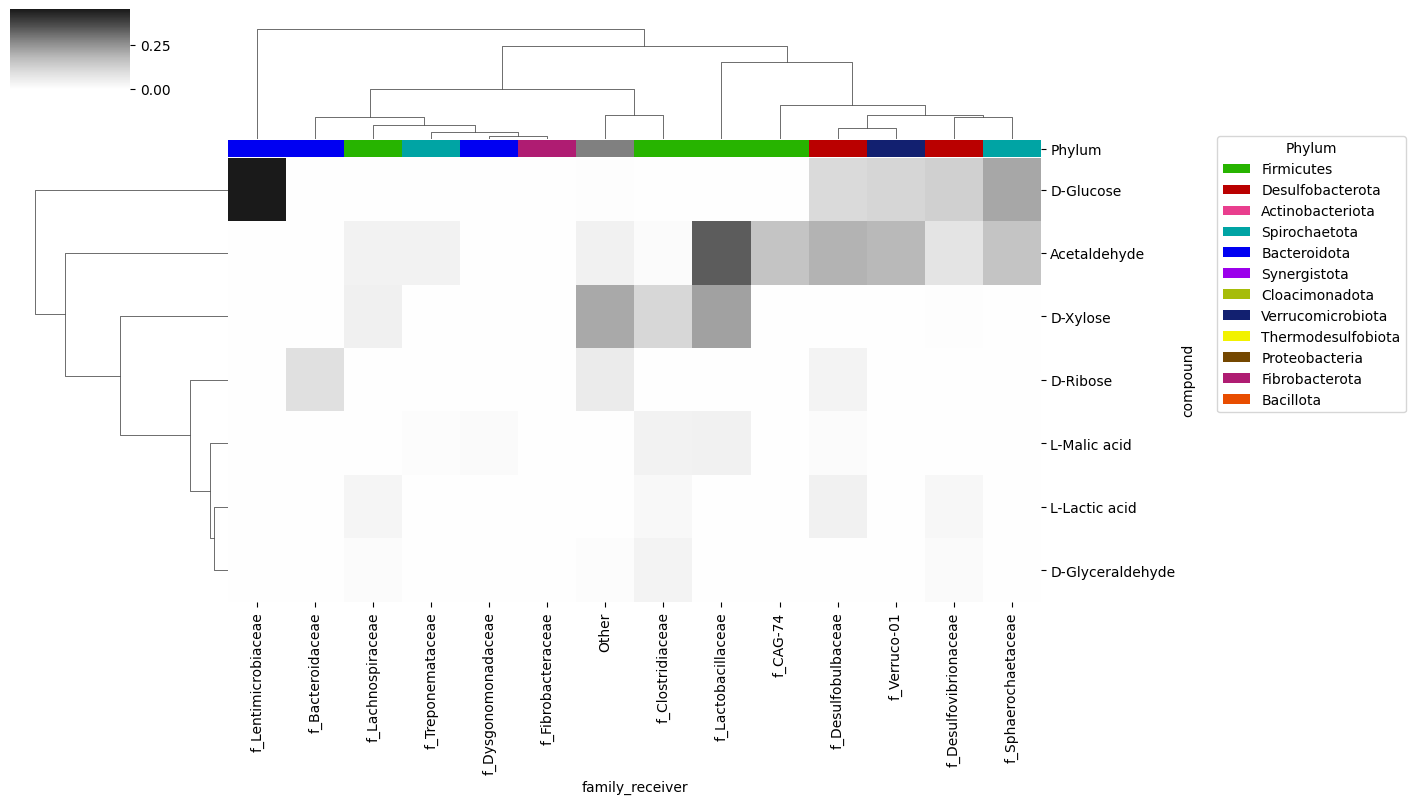

In [410]:
fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.01,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,8),                
                cbar_pos=(0,0.9,0.1,0.1))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/clustermap_prod_5/max_interact_consume_norm.png",bbox_inches='tight')

### Production: Most shared compounds (amino acids and statistically interesting compounds)

In [411]:
steadier_sample_not_from_env = steadier_sample[(steadier_sample.donor!="environment")].copy()

In [412]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()
steadier_sample_prod_overview = steadier_sample_prod_overview.T/steadier_sample_prod_overview.sum(axis=1)
steadier_sample_prod_overview = steadier_sample_prod_overview.T[["D-Aspartic acid","L-Aspartic acid","Guanine","Uracil","L-Arginine","L-Lysine","Thymine"]]
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()

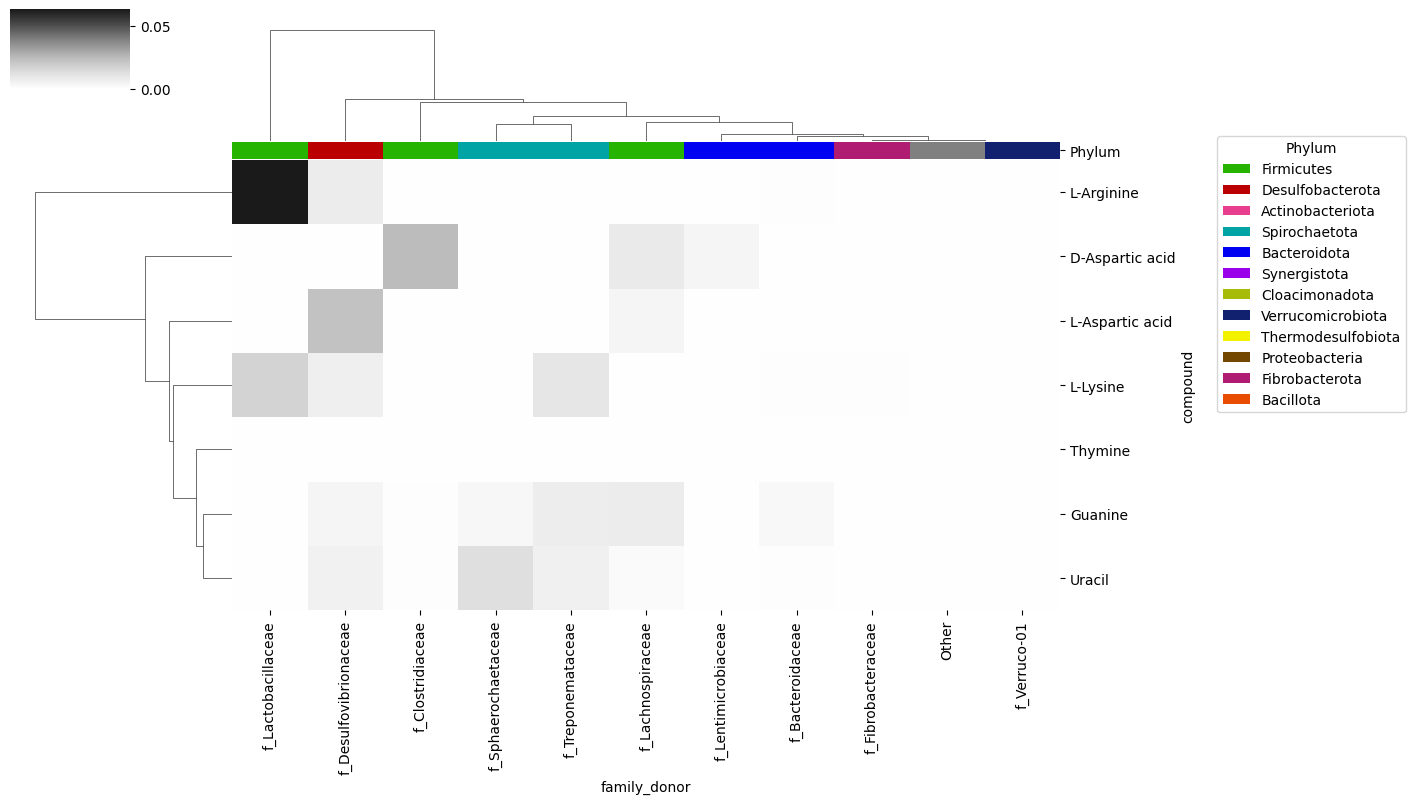

In [413]:
fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.001,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,8),
                cbar_pos=(0,0.9,0.1,0.1))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/clustermap_prod_5/max_interact_interesting_prod_norm.png",bbox_inches='tight')

### Consumers: Most shared compounds (amino acids and statistically interesting compounds) - normalized by family

In [414]:
steadier_sample_not_from_env = steadier_sample[(steadier_sample.receiver!="environment")].copy()

In [415]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_receiver","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()
steadier_sample_prod_overview = steadier_sample_prod_overview.T/steadier_sample_prod_overview.sum(axis=1)
steadier_sample_prod_overview = steadier_sample_prod_overview.T[["D-Aspartic acid","L-Aspartic acid","Guanine","Uracil","L-Arginine","L-Lysine","Thymine"]]
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()

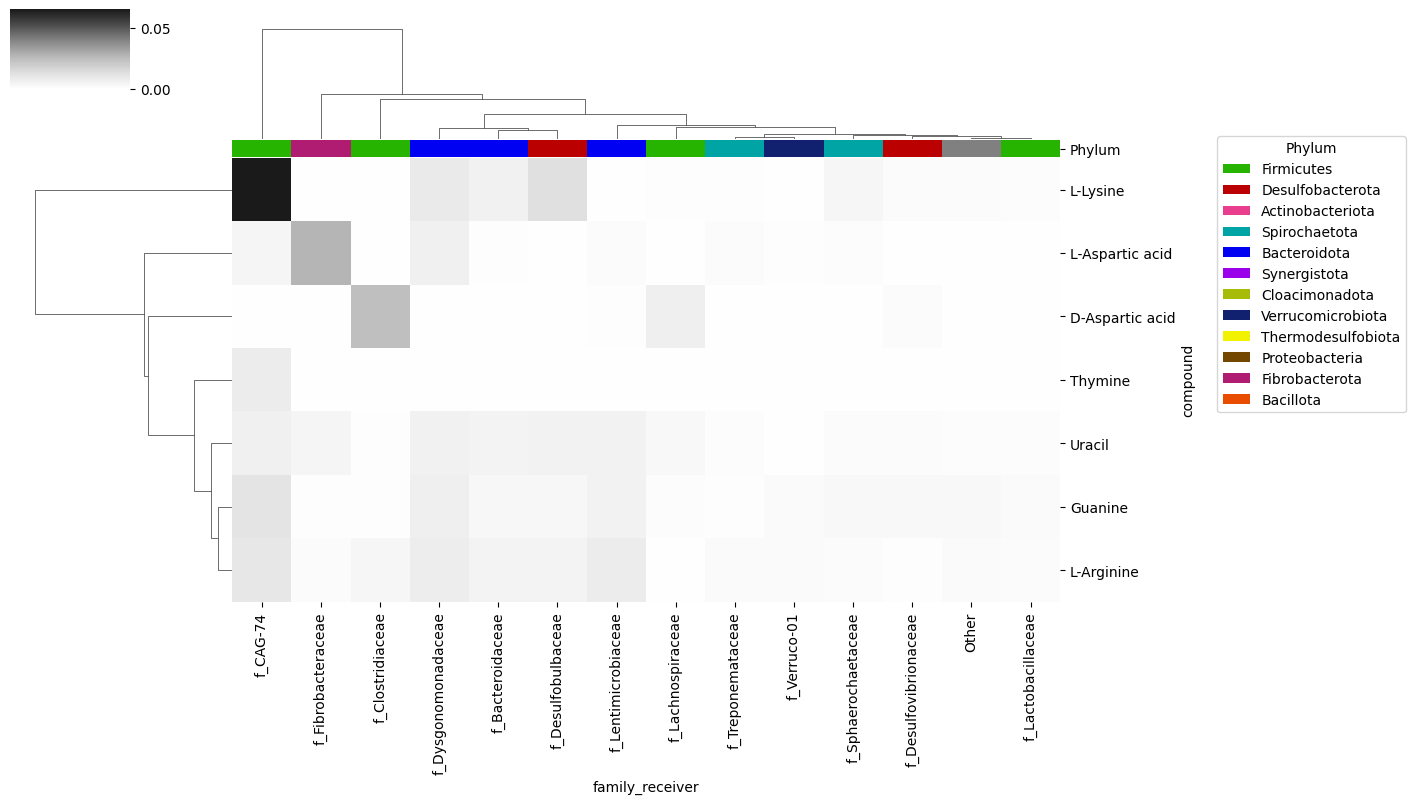

In [416]:
fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,8),
               cbar_pos=(0,0.9,0.1,0.1))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/clustermap_prod_5/max_interact_interesting_consume_norm.png",bbox_inches='tight')

In [417]:
steadier_sample[(steadier_sample.compound.str.contains("Hydrogen sulfide")) & (steadier_sample.family_receiver=="environment")].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
f_Desulfovibrionaceae    0.004842
Other                    0.002267
f_Lachnospiraceae        0.002203
f_Sphaerochaetaceae      0.001601
f_Bacteroidaceae         0.001483
f_Verruco-01             0.000599
f_Treponemataceae        0.000547
f_Clostridiaceae         0.000482
f_Lentimicrobiaceae      0.000395
f_Dysgonomonadaceae      0.000174
f_Desulfobulbaceae       0.000105
f_CAG-74                 0.000089
f_Fibrobacteraceae       0.000040
Name: mass_rate*frequency, dtype: float64

In [418]:
steadier_sample[(steadier_sample.compound.str.contains("Succinate")) & (steadier_sample.family_receiver=="environment")].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
f_Clostridiaceae         2.890921e-03
f_Desulfovibrionaceae    2.092049e-05
f_Treponemataceae        1.770341e-05
f_Bacteroidaceae         6.161451e-06
f_Sphaerochaetaceae      9.452345e-07
f_Lactobacillaceae       5.819777e-07
Other                    2.532044e-08
Name: mass_rate*frequency, dtype: float64

In [419]:
steadier_sample[(steadier_sample.compound.str.contains("Thymine"))].groupby("family_receiver").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_receiver
f_Lachnospiraceae        0.000019
Other                    0.000016
f_CAG-74                 0.000014
f_Desulfovibrionaceae    0.000006
f_Sphaerochaetaceae      0.000004
Name: mass_rate*frequency, dtype: float64

In [420]:
steadier_sample[(steadier_sample.compound.str.contains("L-Lactic acid"))].groupby("family_receiver").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_receiver
environment              0.005428
f_Lachnospiraceae        0.003170
f_Desulfovibrionaceae    0.001845
f_Clostridiaceae         0.001774
Other                    0.000233
f_Desulfobulbaceae       0.000155
Name: mass_rate*frequency, dtype: float64

In [421]:
steadier_sample[(steadier_sample.compound.str.contains("L-Lactic acid"))].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
f_Desulfovibrionaceae    8.868835e-03
f_Clostridiaceae         1.790380e-03
f_Lachnospiraceae        1.489201e-03
Other                    2.547908e-04
f_Desulfobulbaceae       1.944876e-04
f_Verruco-01             6.071848e-06
f_Dysgonomonadaceae      9.080202e-07
Name: mass_rate*frequency, dtype: float64

In [422]:
steadier_sample[(steadier_sample.compound=="Carbon monoxide") & (steadier_sample.family_receiver=="environment")].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
f_Desulfovibrionaceae    0.009522
f_Lachnospiraceae        0.008934
Other                    0.003154
f_Bacteroidaceae         0.001906
f_Treponemataceae        0.000740
f_Verruco-01             0.000632
Name: mass_rate*frequency, dtype: float64

## Production/consumption with genus and family grouping

**Change names of family for readability and better grouping**

In [423]:
all_mags_paper_reduced = all_mags_paper.copy()

all_mags_paper_reduced[all_mags_paper_reduced["new_coverage"]>10][["Source","Substrate","Family","new_coverage"]].sort_values(["Source","Substrate"])

all_mags_paper_reduced["Family"] = all_mags_paper.apply(lambda row: "g_"+row.Genus if isinstance(row.Genus,str) else "f_"+row.Family,axis=1)

total_members_family = all_mags_paper_reduced.groupby("Family").count()["Source"].to_dict()
#all_mags_paper_reduced["Family"] = all_mags_paper_reduced.apply(lambda row: row.Family if total_members_family[row.Family]>1 else "Other",axis=1)


In [424]:
all_mags_paper_reduced

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH14-bin.1,Compost_Digestate,Xylan,99.37,0.32,Bacteria,Firmicutes,Clostridia,Lachnospirales,g_Lacrimispora,Lacrimispora,Lacrimispora amygdalina_A,5147597.0,48.0,197896.0,4902.0,CH14-bin.1,54.707294
CH14-bin.2,Compost_Digestate,Xylan,99.37,0.63,Bacteria,Firmicutes,Clostridia,Lachnospirales,g_Robinsoniella,Robinsoniella,Robinsoniella peoriensis,5647052.0,70.0,172899.0,4618.0,CH14-bin.2,18.831114
CH14-bin.4,Compost_Digestate,Xylan,99.41,0.59,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,g_Desulfovibrio,Desulfovibrio,Desulfovibrio legallii,2785393.0,156.0,29605.0,2420.0,CH14-bin.4,2.741818
CH9-bin.0,Cow_Manure,Xylan,99.03,2.82,Bacteria,Actinobacteriota,Actinomycetia,Actinomycetales,g_Bifidobacterium,Bifidobacterium,NaN,2513253.0,38.0,128964.0,2055.0,CH9-bin.0,70.451904
CH9-bin.6,Cow_Manure,Xylan,100.00,0.00,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,g_Erysipelatoclostridium,Erysipelatoclostridium,Erysipelatoclostridium ramosum,3208880.0,42.0,126720.0,3152.0,CH9-bin.6,9.662049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH8-bin.21,Cow_Manure,Avicel,94.43,3.02,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,g_DMER64,DMER64,DMER64 sp002408205,2584209.0,141.0,46653.0,2199.0,CH8-bin.21,1.713873
CH8-bin.8,Cow_Manure,Avicel,100.00,0.00,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,g_Desulfocurvibacter,Desulfocurvibacter,NaN,3921615.0,63.0,193203.0,3587.0,CH8-bin.8,1.574371
CH8-bin.29,Cow_Manure,Avicel,95.99,0.55,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,g_Proteiniphilum,Proteiniphilum,Proteiniphilum sp012837345,2514759.0,114.0,36600.0,2110.0,CH8-bin.29,1.084728


**Create dictionaries to translate components into larger groups - MAG-> family, compound-> super_class**

In [425]:
MAGs_steady_com = list(set(steadier_sample_prod.donor.values))

MAG2sour_sub_id = pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None)
MAG2sour_sub_id.columns=["MAG","community_id"]

met2superclass_dict = pd.read_csv("../output/met_chebi_class.tsv",sep="\t",index_col=0)["self defined super class"].to_dict()

family_groups,mag2family_dict = mag2family(all_mags_paper_reduced)

**Process samples**

In [426]:
SC1_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])
steadier_sample["mass_rate"] = steadier_sample["mass_rate"]*1000
steadier_sample = steadier_sample[(steadier_sample.rate>1e-6)]

In [427]:
steadier_sample.loc[:,"family_donor"] = steadier_sample.apply(family_donor,axis=1).copy()
steadier_sample.loc[:,"family_receiver"] = steadier_sample.apply(family_receiver,axis=1).copy()
steadier_sample = steadier_sample[steadier_sample.compound.isin(met2superclass_dict.keys())].copy()
steadier_sample.loc[:,"super_class"] = steadier_sample.apply(lambda x: met2superclass_dict[x.compound],axis=1)

compounds = steadier_sample["compound"].map(met2metname)
compounds = compounds.map(change_name)
steadier_sample.drop("compound",axis=1,inplace=True)
steadier_sample.loc[:,"compound"] = compounds
steadier_sample["mass_rate*frequency"]=steadier_sample["mass_rate"]*steadier_sample["frequency"]

**Create colors**

In [428]:
phyla_lut, unique_phyla, phylum_colors = color_func.phylum_colors_func()

families = list(set(list(steadier_sample.family_donor.unique()) + list(steadier_sample.family_receiver.unique())))

families.remove("environment")

In [429]:
phyla = [all_mags_paper_reduced.loc[all_mags_paper_reduced.Family==family]["Phylum"][0] for family in families]
colors = [phyla_lut[phylum] for phylum in phyla]

color_df = pd.DataFrame({"Family_names":families,"Phylum":colors})
color_df.set_index("Family_names",inplace=True)

### Production - shared with environment or another community member (compounds observed experimentally)

In [430]:
steadier_sample_not_from_env = steadier_sample[steadier_sample.donor!="environment"].copy()

In [431]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)

# Missing 1-propanol
steadier_sample_prod_overview = steadier_sample_prod_overview[["CO2","Hydrogen","Acetic acid","Ethanol","Propionic acid","Butyric acid","L-Lactic acid","Formic acid","Caproic acid","Isobutyric acid"]]


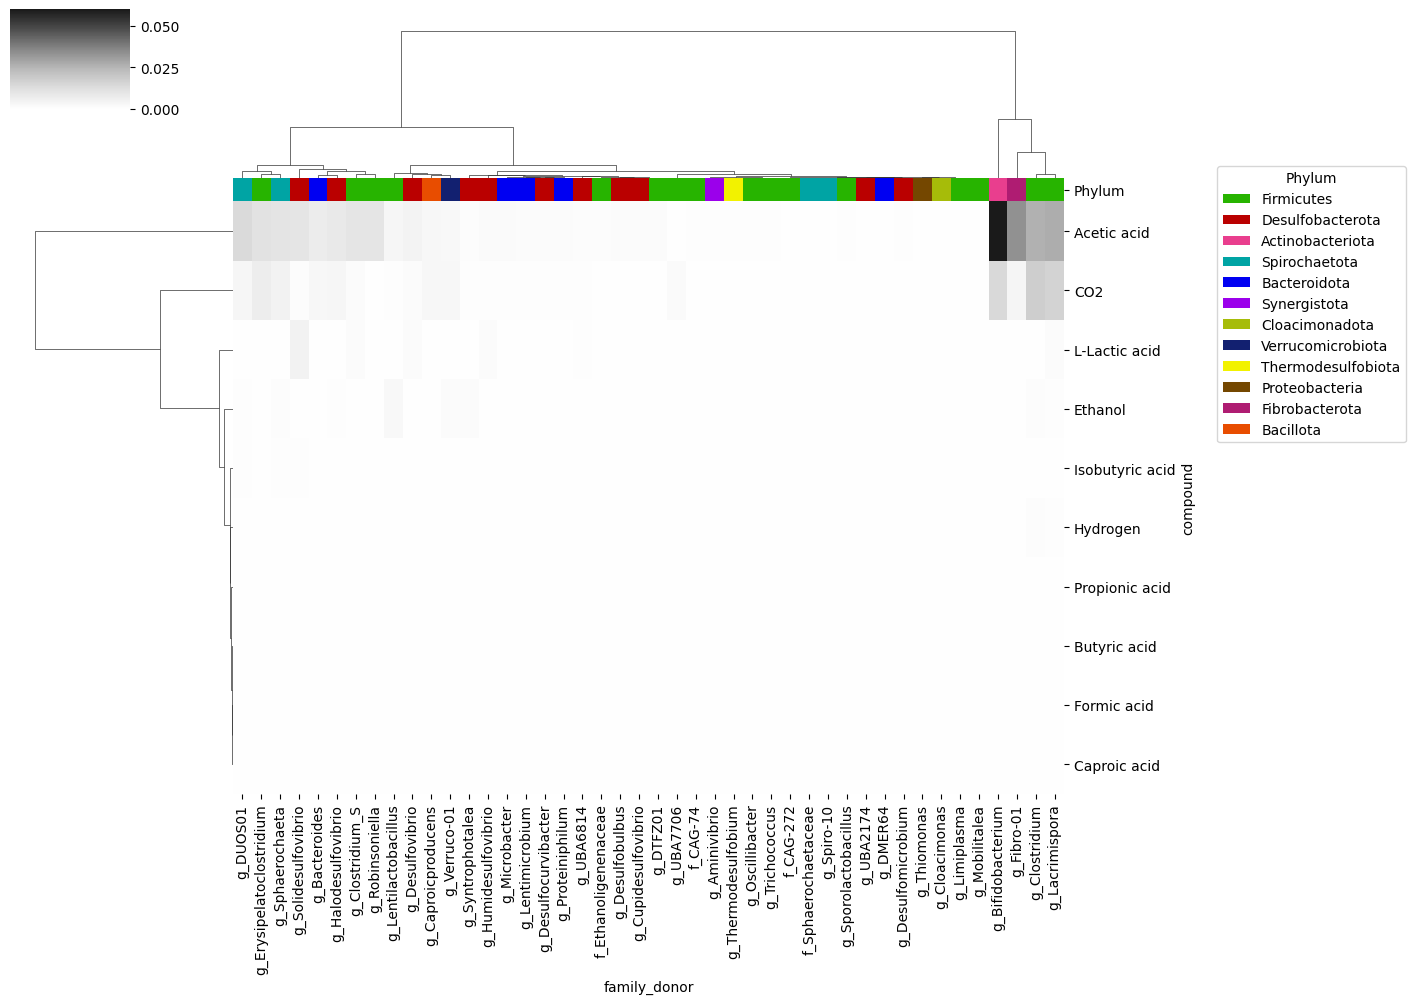

In [432]:
fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.2,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,10),
              cbar_pos=(0,0.9,0.1,0.1))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/clustermap_prod_5/exp_prod_env_and_others.png",bbox_inches='tight')

In [433]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
# Missing 1-propanol
steadier_sample_prod_overview = steadier_sample_prod_overview/steadier_sample_prod_overview.sum()
steadier_sample_prod_overview = steadier_sample_prod_overview[["CO2","Hydrogen","Acetic acid","Ethanol","Propionic acid","Butyric acid","L-Lactic acid","Formic acid","Caproic acid","Isobutyric acid"]]
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()

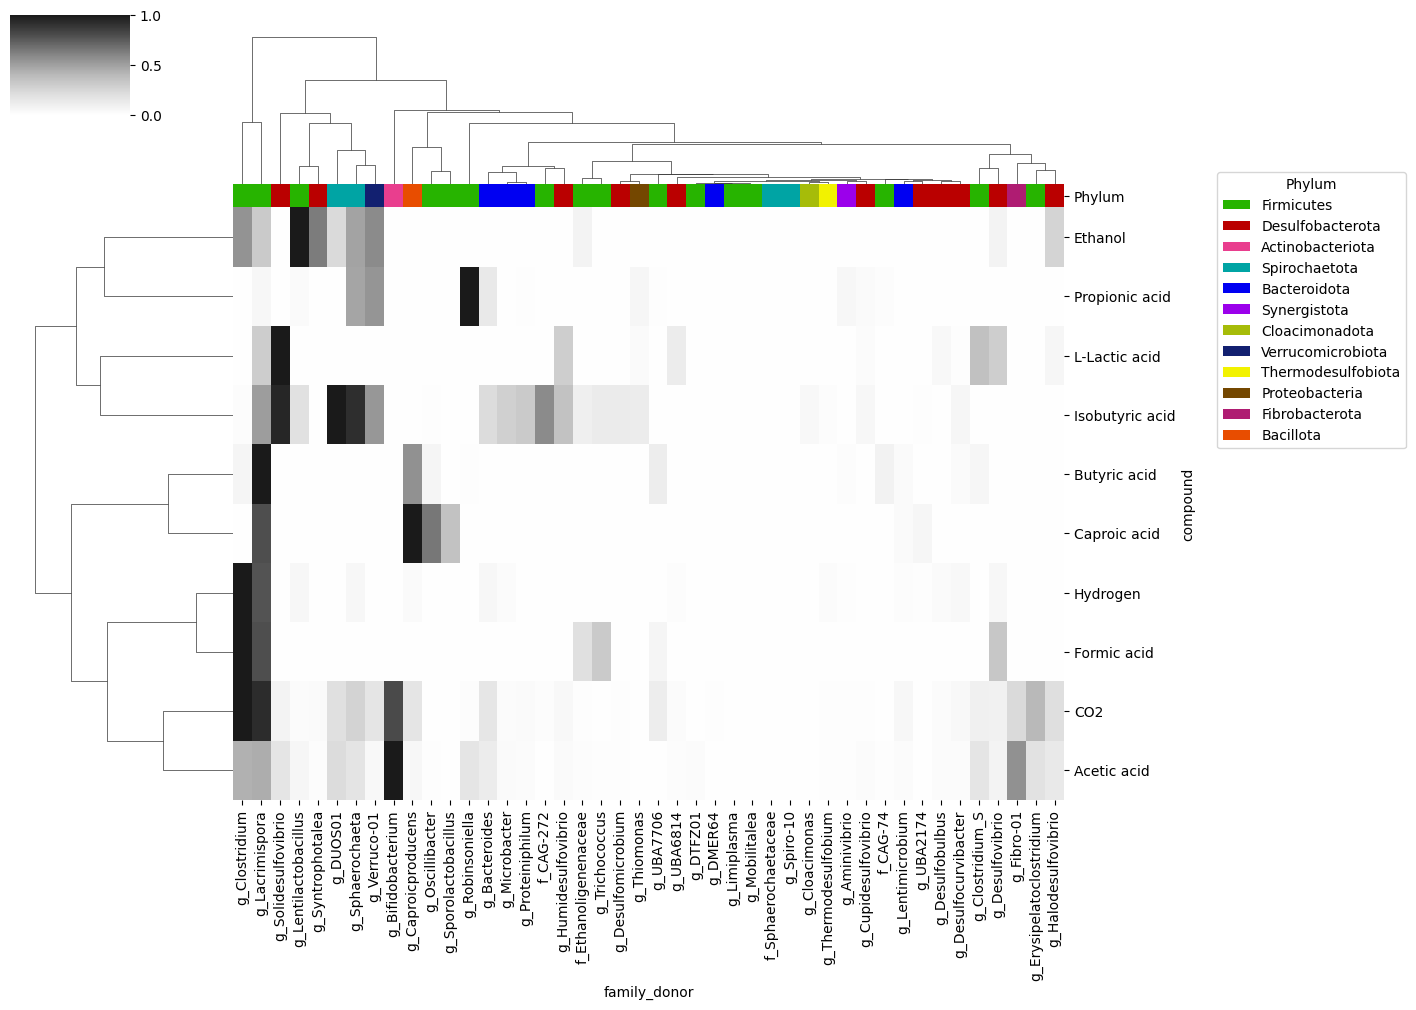

In [434]:
fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.2,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=False,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,10),
              cbar_pos=(0,0.9,0.1,0.1))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/clustermap_prod_5/exp_prod_env_and_others_norm_comp.png",bbox_inches='tight')

In [435]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
# Missing 1-propanol
steadier_sample_prod_overview = steadier_sample_prod_overview.T/steadier_sample_prod_overview.sum(axis=1)
steadier_sample_prod_overview = steadier_sample_prod_overview.T[["CO2","Hydrogen","Acetic acid","Ethanol","Propionic acid","Butyric acid","L-Lactic acid","Formic acid","Caproic acid","Isobutyric acid"]]
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[steadier_sample_prod_overview.sum(axis=1)>0].copy()

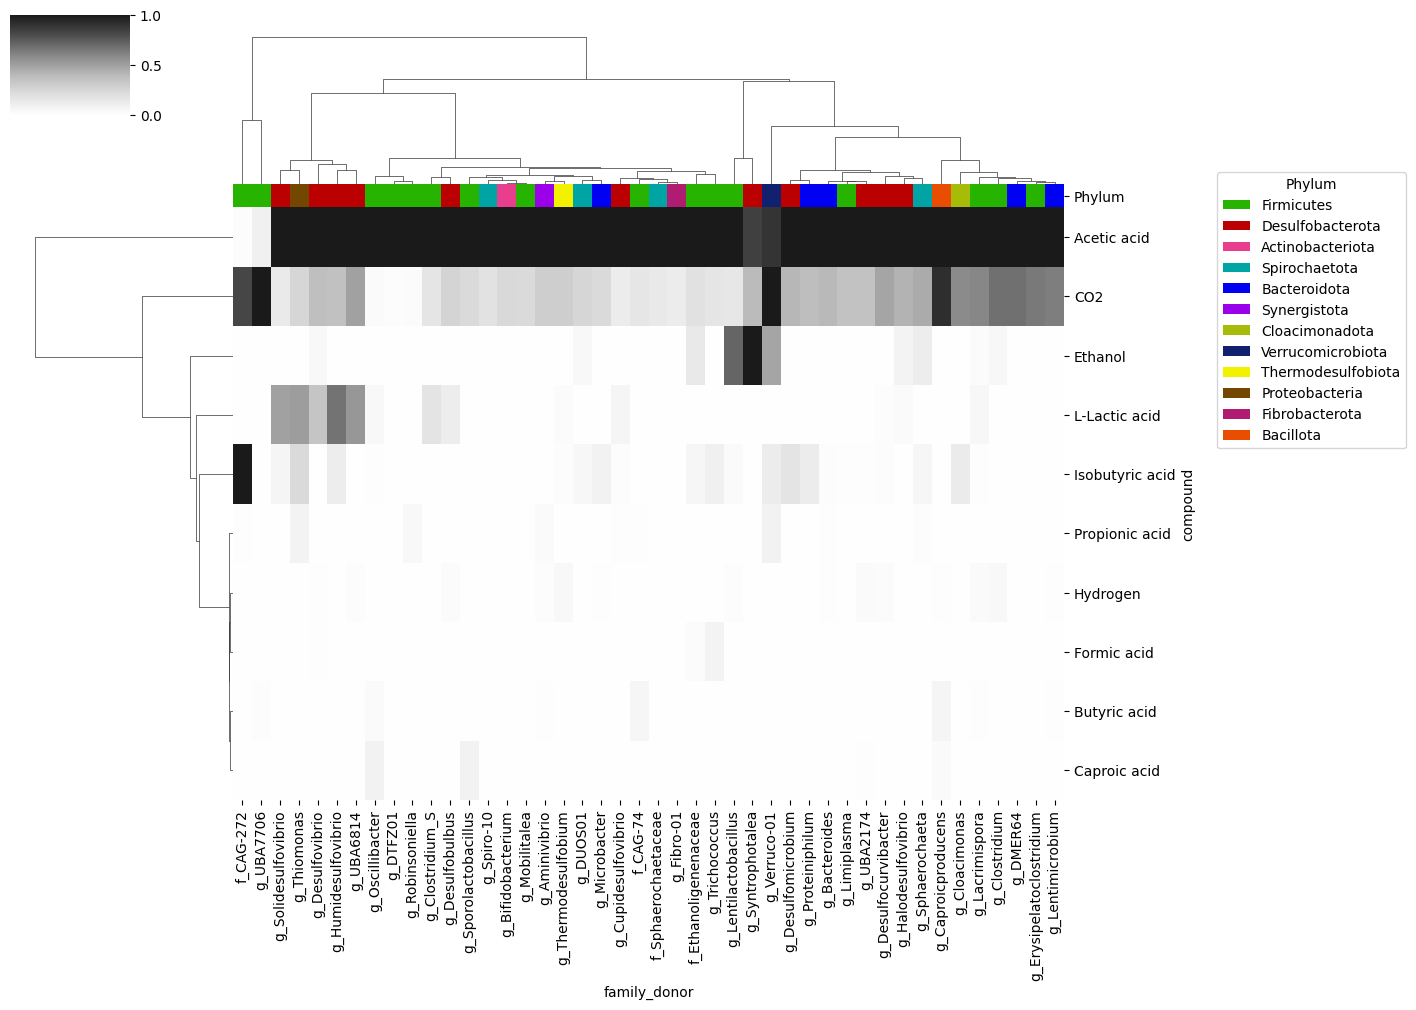

In [436]:
fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.2,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,10),
               cbar_pos=(0,0.9,0.1,0.1))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)


fig.savefig("Figures/clustermap_prod_5/exp_prod_env_and_others_norm.png",bbox_inches='tight')

### Propan-diol

In [437]:
steadier_sample[(steadier_sample.compound.str.contains("Propane-")) & (steadier_sample.family_receiver=="environment")].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
g_Bifidobacterium       0.022698
g_Robinsoniella         0.000264
g_Verruco-01            0.000162
g_Trichococcus          0.000132
g_Cupidesulfovibrio     0.000088
g_Spiro-10              0.000027
g_Thiomonas             0.000024
g_Proteiniphilum        0.000017
g_Lentilactobacillus    0.000008
g_Limiplasma            0.000002
Name: mass_rate*frequency, dtype: float64

In [438]:
steadier_sample[(steadier_sample.compound.str.contains("Formald")) & (steadier_sample.family_receiver=="environment")].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
g_Fibro-01              1.793457e-02
g_Clostridium           4.470394e-06
g_Desulfovibrio         2.020146e-06
g_Halodesulfovibrio     1.433846e-06
g_UBA6814               1.180729e-06
g_Lentimicrobium        9.092306e-07
g_Solidesulfovibrio     5.053445e-07
g_Desulfocurvibacter    3.000919e-07
g_Cupidesulfovibrio     1.612107e-07
g_Aminivibrio           9.847468e-08
g_Thermodesulfobium     9.427924e-09
Name: mass_rate*frequency, dtype: float64

In [439]:
steadier_sample[(steadier_sample.compound.str.contains("Succinate")) & (steadier_sample.family_receiver=="environment")].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
g_Clostridium           2.890921e-03
g_Spiro-10              1.770341e-05
g_Desulfovibrio         1.535140e-05
g_Bacteroides           6.161451e-06
g_Desulfocurvibacter    5.569086e-06
g_Sphaerochaeta         9.452345e-07
g_Lentilactobacillus    5.819777e-07
f_CAG-272               2.532044e-08
Name: mass_rate*frequency, dtype: float64

In [440]:
steadier_sample[(steadier_sample.compound=="Carbon monoxide") & (steadier_sample.family_receiver=="environment")].groupby("family_donor").sum()["mass_rate*frequency"].sort_values(ascending=False)

family_donor
g_Lacrimispora          0.006365
g_Halodesulfovibrio     0.004842
g_Solidesulfovibrio     0.003611
g_Robinsoniella         0.002569
g_DTFZ01                0.002205
g_Bacteroides           0.001906
g_Oscillibacter         0.000792
g_DUOS01                0.000740
g_Verruco-01            0.000632
g_Cupidesulfovibrio     0.000327
g_Desulfovibrio         0.000276
g_UBA6814               0.000263
g_Desulfocurvibacter    0.000203
g_UBA2174               0.000157
Name: mass_rate*frequency, dtype: float64

In [441]:
hexanoate_producers = steadier_sample[steadier_sample.compound.str.contains("Hexanoate")].donor.unique()
hexanoate_producers

array([], dtype=object)

In [442]:
butyrate_producers = steadier_sample[steadier_sample.compound.str.contains("Butyrate")].donor.unique()
butyrate_producers

array([], dtype=object)

In [443]:
steadier_sample[(steadier_sample.receiver.isin(hexanoate_producers)) & (steadier_sample.donor!="environment")].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

Series([], Name: mass_rate*frequency, dtype: float64)

In [444]:
steadier_sample[(steadier_sample.receiver.isin(hexanoate_producers))].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

Series([], Name: mass_rate*frequency, dtype: float64)

In [445]:
steadier_sample[(~steadier_sample.receiver.isin(hexanoate_producers)) & (steadier_sample.donor!="environment")].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

compound
Acetic acid             0.267322
CO2                     0.095405
D-Xylose                0.076415
Acetaldehyde            0.037936
Carbon monoxide         0.024888
D-Glucose               0.023664
(R)-Propane-1,2-diol    0.023295
Formaldehyde            0.017946
D-Ribose                0.016897
Hydrogen sulfide        0.014973
Name: mass_rate*frequency, dtype: float64

In [446]:
steadier_sample[(~steadier_sample.receiver.isin(hexanoate_producers))].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

compound
Acetic acid                                     0.267322
Xylan (4 backbone units, 1 glcur side chain)    0.176204
CO2                                             0.095405
Cellulose (n=5 repeating units)                 0.085314
Cellobiose                                      0.082993
Cellulose (n=4 repeating units)                 0.080462
D-Xylose                                        0.076415
Xylobiose                                       0.067739
Acetaldehyde                                    0.037936
Carbon monoxide                                 0.024888
Name: mass_rate*frequency, dtype: float64

In [447]:
steadier_sample[(steadier_sample.receiver.isin(butyrate_producers)) & (steadier_sample.donor!="environment")].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

Series([], Name: mass_rate*frequency, dtype: float64)

In [448]:
steadier_sample[(steadier_sample.receiver.isin(butyrate_producers))].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

Series([], Name: mass_rate*frequency, dtype: float64)

In [449]:
steadier_sample[(~steadier_sample.receiver.isin(butyrate_producers)) & (steadier_sample.donor!="environment")].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

compound
Acetic acid             0.267322
CO2                     0.095405
D-Xylose                0.076415
Acetaldehyde            0.037936
Carbon monoxide         0.024888
D-Glucose               0.023664
(R)-Propane-1,2-diol    0.023295
Formaldehyde            0.017946
D-Ribose                0.016897
Hydrogen sulfide        0.014973
Name: mass_rate*frequency, dtype: float64

In [450]:
steadier_sample[(~steadier_sample.receiver.isin(butyrate_producers))].groupby("compound").sum()["mass_rate*frequency"].sort_values(ascending=False).head(10)

compound
Acetic acid                                     0.267322
Xylan (4 backbone units, 1 glcur side chain)    0.176204
CO2                                             0.095405
Cellulose (n=5 repeating units)                 0.085314
Cellobiose                                      0.082993
Cellulose (n=4 repeating units)                 0.080462
D-Xylose                                        0.076415
Xylobiose                                       0.067739
Acetaldehyde                                    0.037936
Carbon monoxide                                 0.024888
Name: mass_rate*frequency, dtype: float64